<a href="https://colab.research.google.com/github/oksuzian/Mu2eANL/blob/master/Aging/AgingCountersTestStandUVaBottom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init and load data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
import numpy.polynomial.polynomial as poly
import numpy as np
import scipy
from scipy.optimize import curve_fit
import statistics
import math
from datetime import datetime, timedelta
plt.rcParams.update({'figure.max_open_warning': 0})
import itertools as it

MIN_TEMP=21
MAX_TEMP=22

In [2]:
!pip install gdown
!gdown https://drive.google.com/uc?id=17Yjr34rnNR0GOWfxkGhcwCjZwhnOrDCT

Downloading...
From: https://drive.google.com/uc?id=17Yjr34rnNR0GOWfxkGhcwCjZwhnOrDCT
To: /content/ScanningData_NaturalAgingBottom.txt
100% 2.82M/2.82M [00:00<00:00, 87.7MB/s]


In [3]:
filename = 'ScanningData_NaturalAgingBottom.txt'
with open(filename) as f:
  rows = f.readlines()
  cols = [i for i in range(len(rows[len(rows) - 1].split()))] #this reads the length of the last line and uses that as the number of columns so you don't have to count the number
  data = pd.read_csv(filename, names=cols, sep="\t", header=None, engine='python')
  data[1] = pd.to_datetime(data[1])
  data.set_index(1, inplace=True)

In [4]:
data = data[data.iloc[:, 3:70].gt(0).all(axis=1)]
data.index.names = ['date']
data.drop(0, axis=1, inplace=True)
data.rename({2: 'source'}, axis=1, inplace=True)

column_renames_dict = {}
for col in data.columns[1:].values:
  column_renames_dict[col] = col-3
data.rename(columns=column_renames_dict, inplace=True)
data = data.reset_index()

data.rename({67: 'temp'}, axis=1, inplace=True)


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [5]:
data_signal = data.query('source==1')
data_pedest = data.query('source==0')

In [6]:
def funcC(x, a, b, c): #this is an exponential plus a constant
    return a * np.exp(-b * x) + c
def expo(x, a, b): #this is an exponential
    return a * np.exp(-b * x)
def lin_func(x, a, b): #a linear function
    return a + b * x
def pol0(x, a): #a straight line function
    return a 
def pol2(x, a, b, c): #a second order polynomial
  return (a*x**2) + b*x + c
pd.set_option('max_columns', None)

#Make plots

In [7]:
pd.options.mode.chained_assignment = None 
data_ = data_signal.loc[ (data_signal.temp>MIN_TEMP) & (data_signal.temp<MAX_TEMP)  & (data_signal.index>2000)]
X = (data_.date -  data_.date.to_numpy()[0]).astype('timedelta64[h]')/(365*24) #divides days into years

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  pedestal = 0.15
  data_[chan] = data_[chan] - pedestal #subtracts the pedestal value
  max_current = data_[chan][0:100].mean() 
  data_[chan] = data_[chan]/max_current#normalizing

<Figure size 432x288 with 0 Axes>

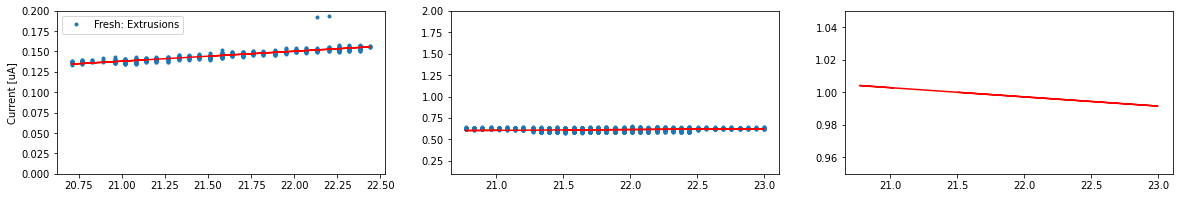

<Figure size 432x288 with 0 Axes>

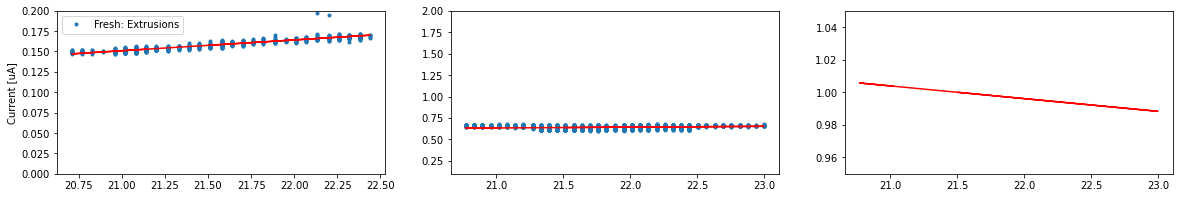

<Figure size 432x288 with 0 Axes>

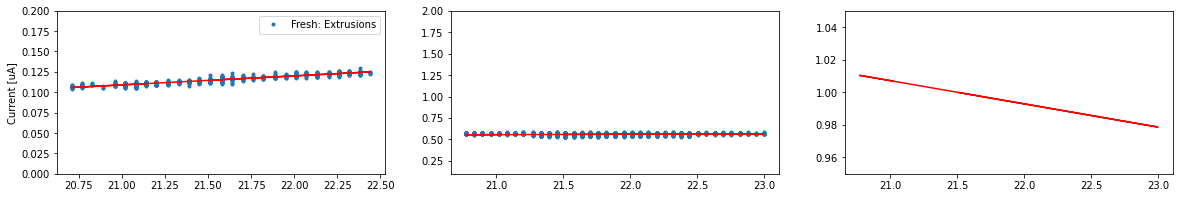

<Figure size 432x288 with 0 Axes>

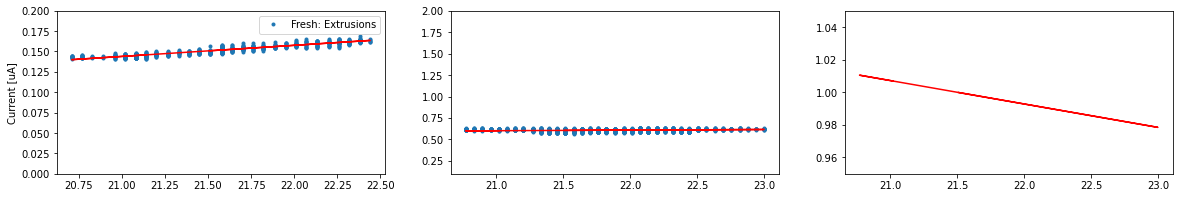

<Figure size 432x288 with 0 Axes>

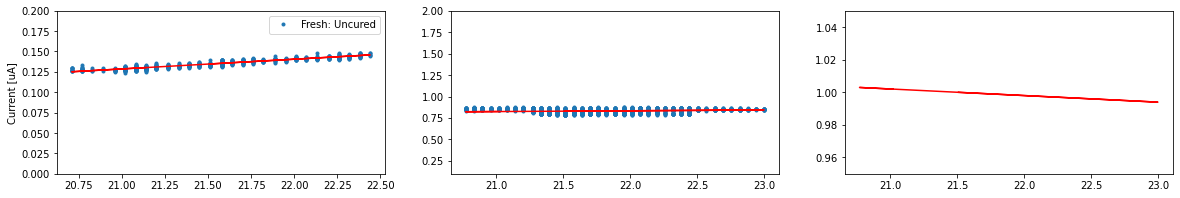

<Figure size 432x288 with 0 Axes>

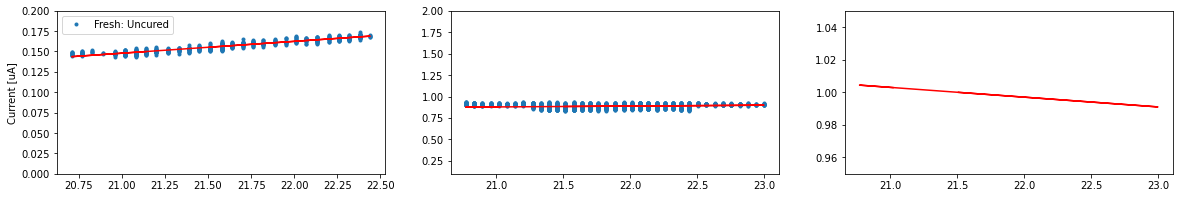

<Figure size 432x288 with 0 Axes>

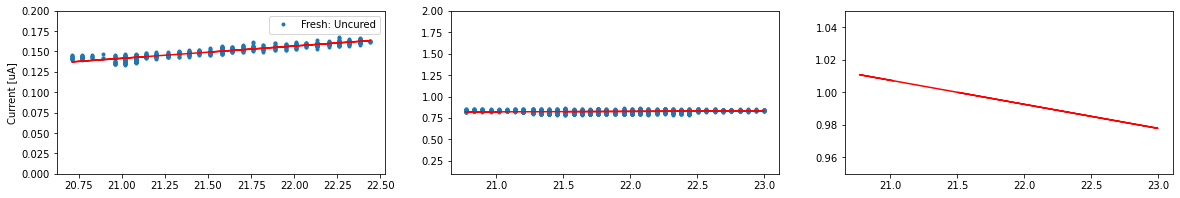

<Figure size 432x288 with 0 Axes>

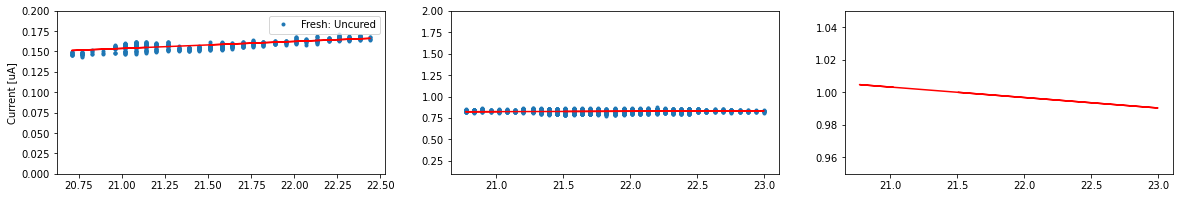

<Figure size 432x288 with 0 Axes>

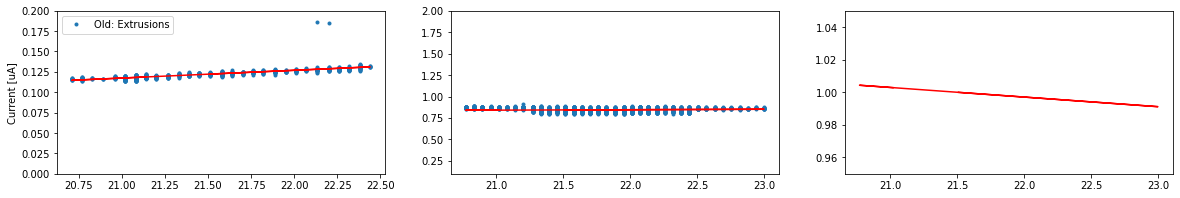

<Figure size 432x288 with 0 Axes>

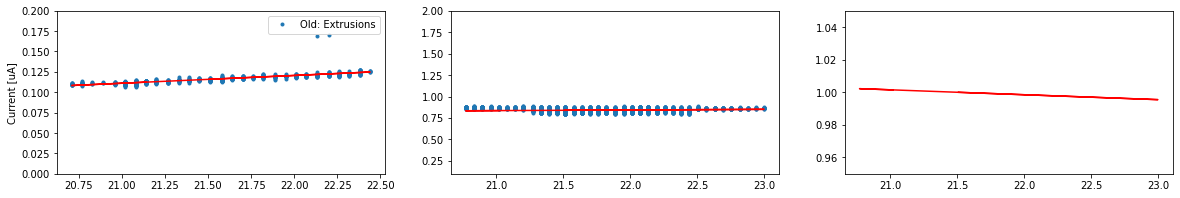

<Figure size 432x288 with 0 Axes>

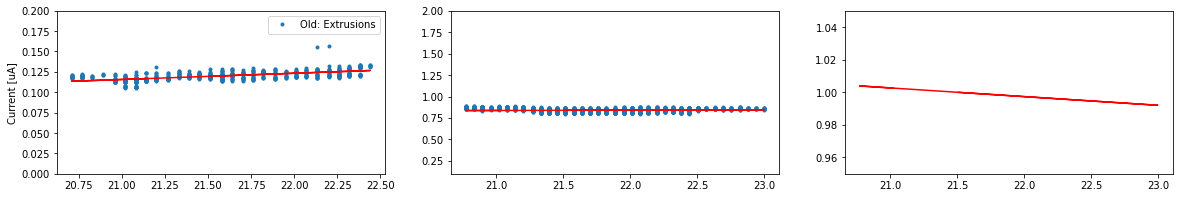

<Figure size 432x288 with 0 Axes>

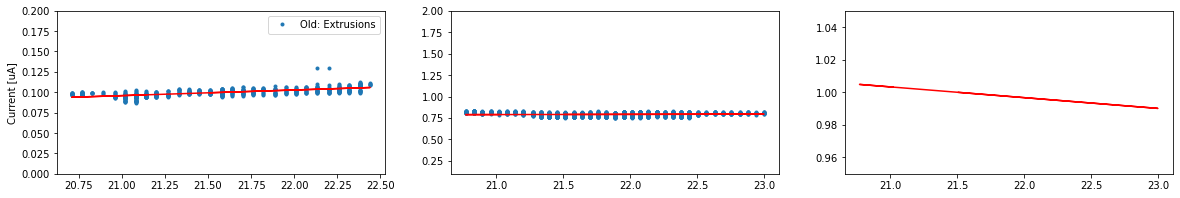

<Figure size 432x288 with 0 Axes>

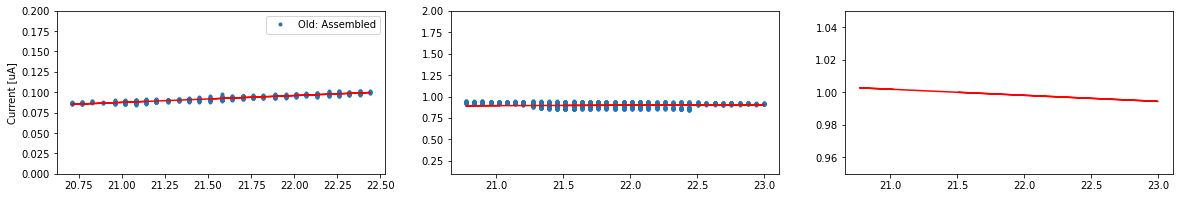

<Figure size 432x288 with 0 Axes>

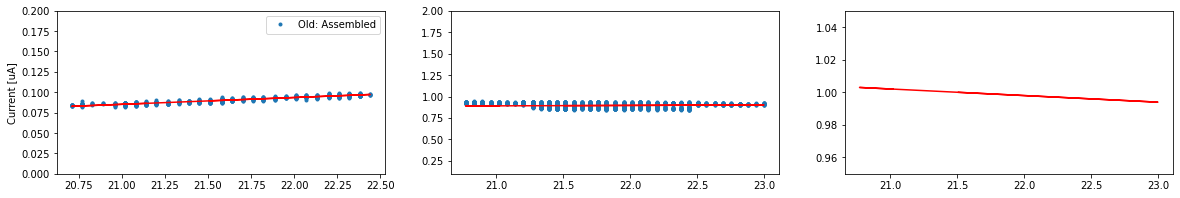

<Figure size 432x288 with 0 Axes>

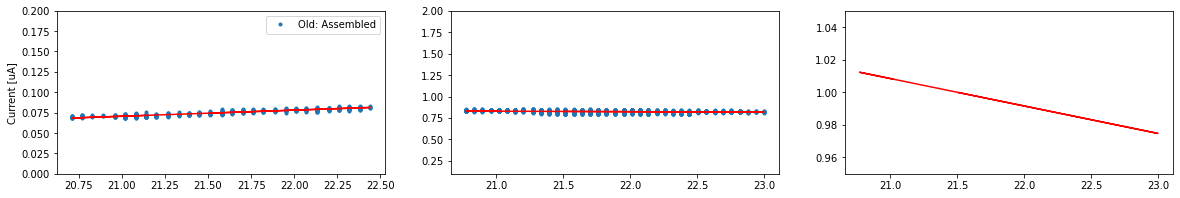

<Figure size 432x288 with 0 Axes>

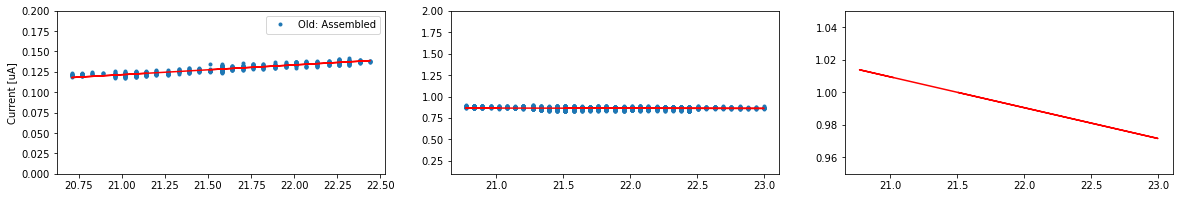

<Figure size 432x288 with 0 Axes>

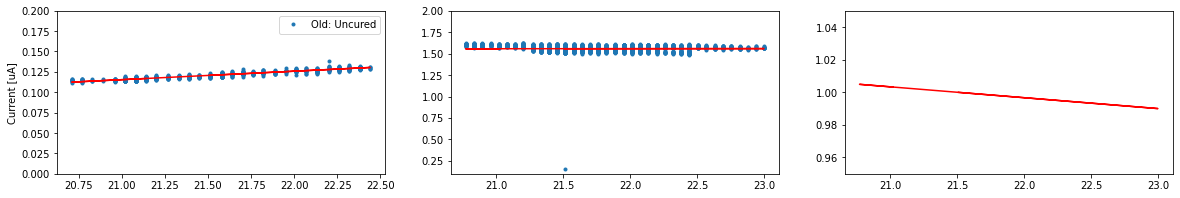

<Figure size 432x288 with 0 Axes>

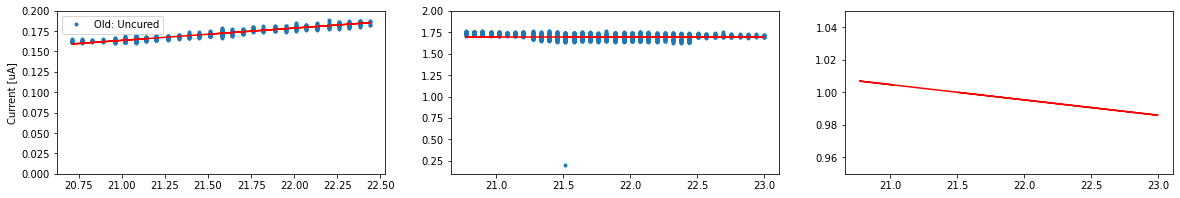

<Figure size 432x288 with 0 Axes>

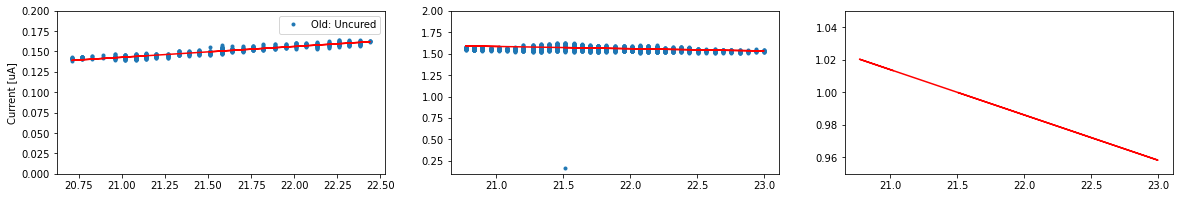

<Figure size 432x288 with 0 Axes>

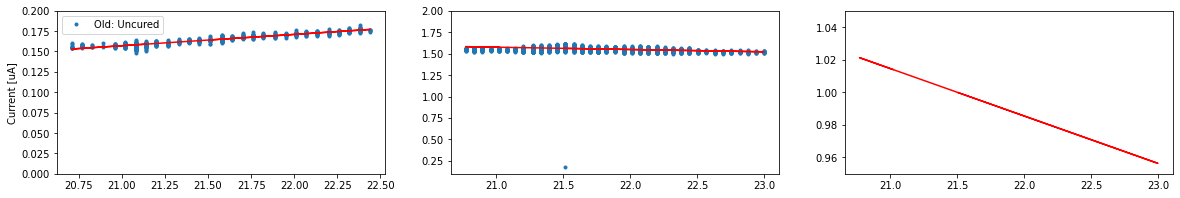

In [9]:
calib_df = pd.DataFrame()

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  plt.figure()

  if chan>=0 and chan<4:
    label='Fresh: Extrusions'
  if chan>=4 and chan<8:
    label='Fresh: Uncured'
  if chan>=8 and chan<12:
    label='Old: Extrusions'
  if chan>=16 and chan<20:
    label='Old: Assembled'
  if chan>=60 and chan<64:
    label='Old: Uncured'

  fig, axs = plt.subplots(1,3, figsize=(20, 3));

  axs[0].plot(data_pedest.temp, data_pedest[chan], '.', label=label);
  popt_ped, pcov = curve_fit(lin_func, data_pedest.temp, data_pedest[chan], p0=(1, 0.05))
  axs[0].plot(data_pedest.temp, lin_func(data_pedest.temp, *popt_ped), 'r-')
  axs[0].set_ylabel('Current [uA]')
  axs[0].set_ylim(0.0, 0.2)
  axs[0].legend()

  axs[1].plot(data_signal.temp, data_signal[chan], '.', label=label);
  popt_sig, pcov = curve_fit(lin_func, data_signal.temp, data_signal[chan], p0=(1, 0.05))
  axs[1].plot(data_signal.temp, lin_func(data_signal.temp, *popt_sig), 'r-')
  axs[1].set_ylim(0.1, 2.)

  FIXED_TEMP = (MAX_TEMP+MIN_TEMP)/2
  SIG_AT_FIXED_TEMP = lin_func(FIXED_TEMP, *(popt_sig-popt_ped))
  axs[2].plot(data_signal.temp, lin_func(data_signal.temp, *(popt_sig-popt_ped))/SIG_AT_FIXED_TEMP, 'r-', label=label)
  axs[2].set_ylim(0.95, 1.05)
  calib_df = calib_df.append({'chan': chan,'name': label, 'const': (popt_sig-popt_ped)[0]/SIG_AT_FIXED_TEMP, 'slope': (popt_sig-popt_ped)[1]/SIG_AT_FIXED_TEMP}, ignore_index=True)

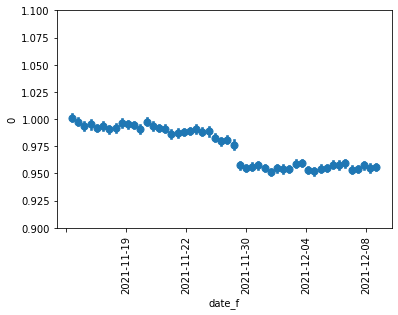

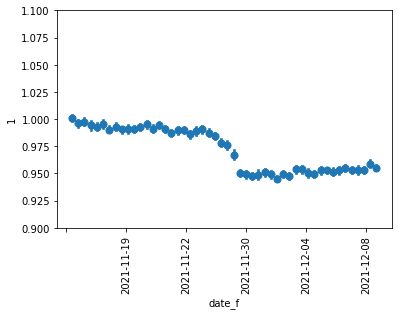

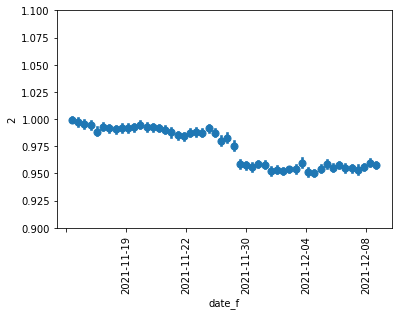

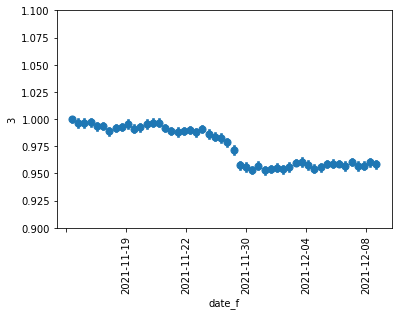

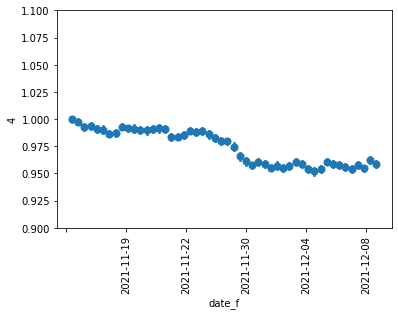

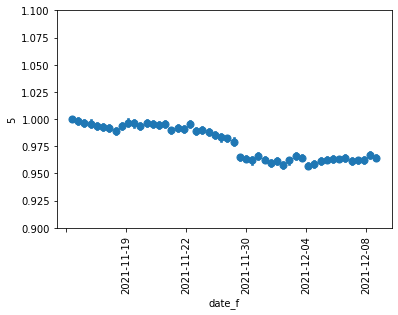

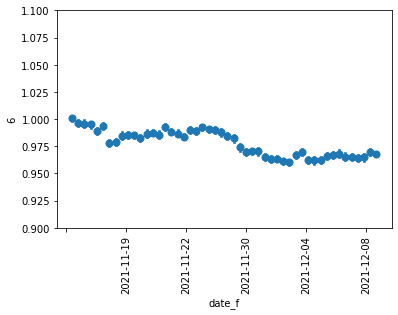

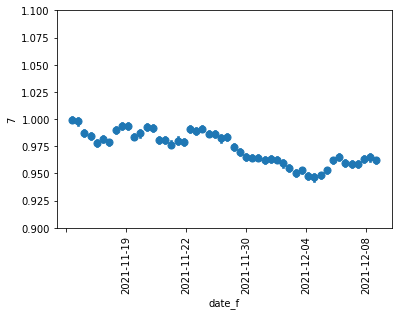

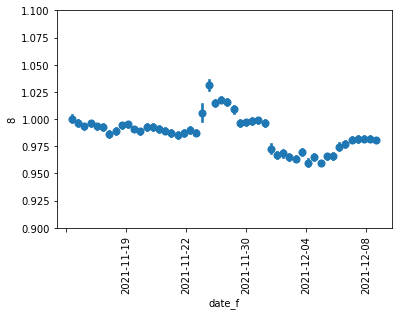

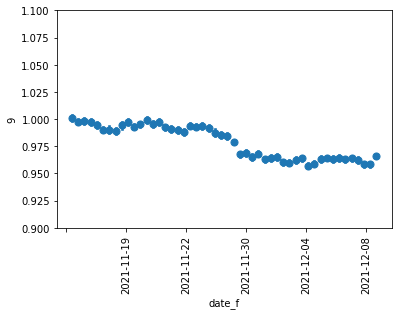

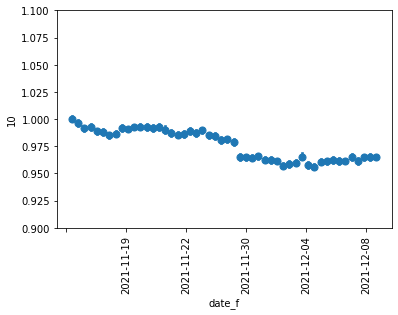

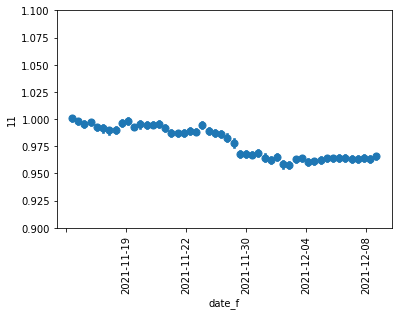

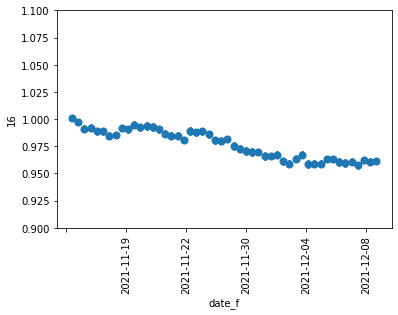

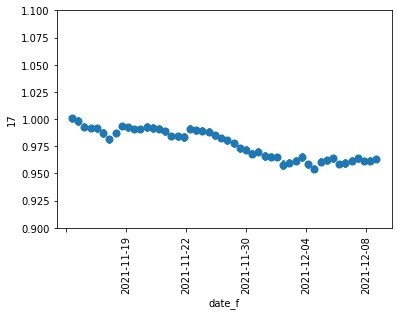

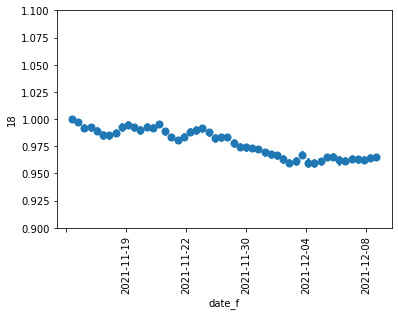

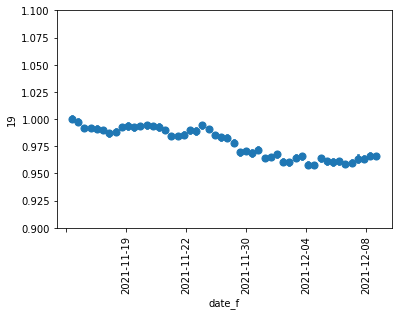

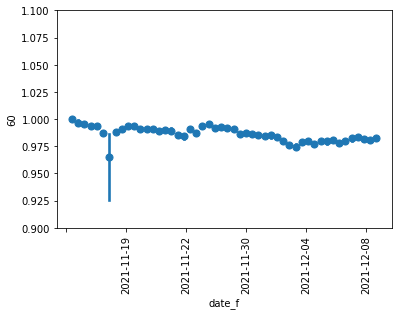

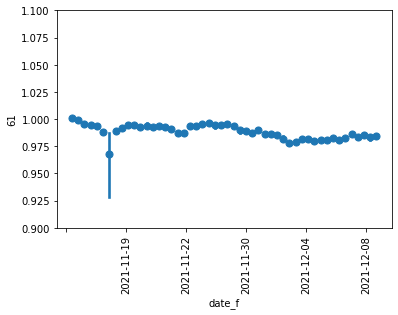

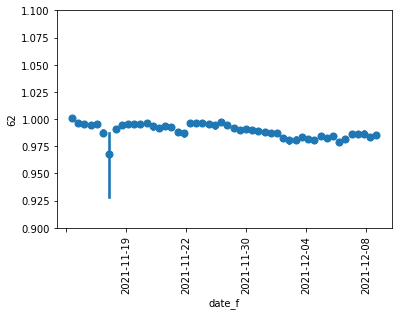

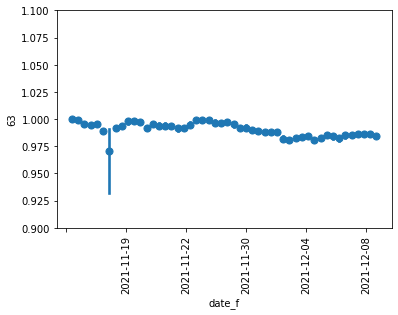

In [10]:
import seaborn as sns

data_['date_f'] = pd.factorize(data_['date'])[0] + 1
mapping = dict(zip(data_['date_f'], data_['date'].dt.date))

for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):

  plt.figure()
  ax = sns.regplot(x=data_['date_f'], y=data_[chan], x_bins=50, fit_reg=None, )
  labels = pd.Series(ax.get_xticks()).map(mapping).fillna('')
  ax.set_xticklabels(labels)

  ax.set_ylim(0.9,1.1)
  ax.tick_params(axis='x', labelrotation = 90);


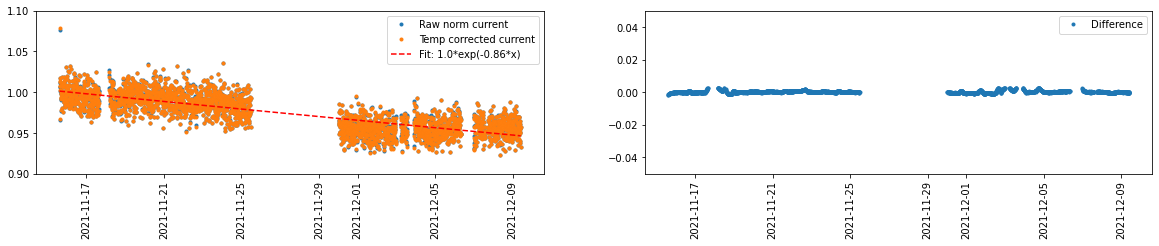

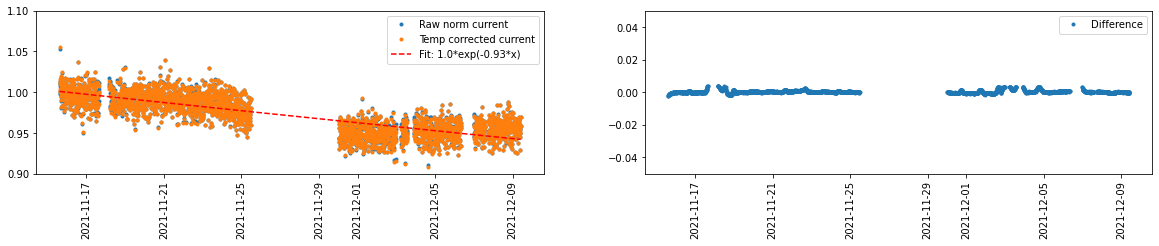

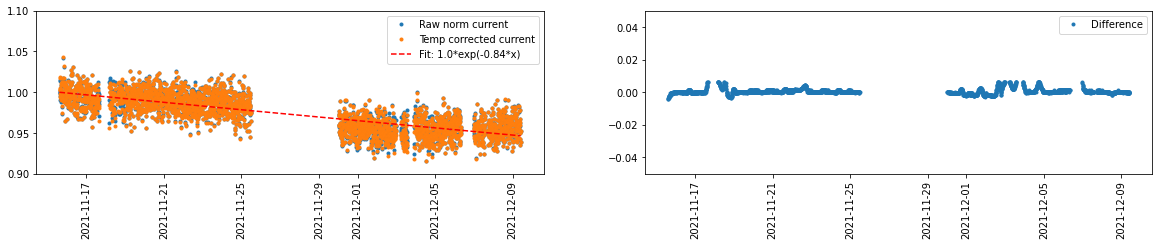

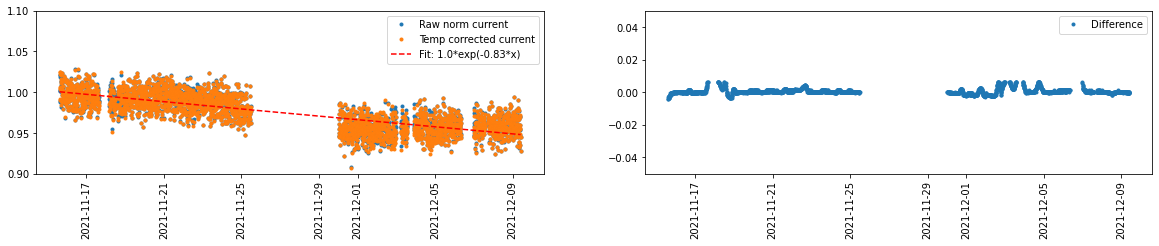

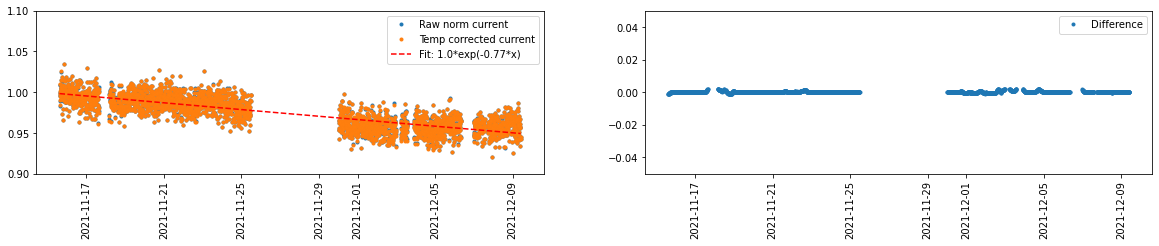

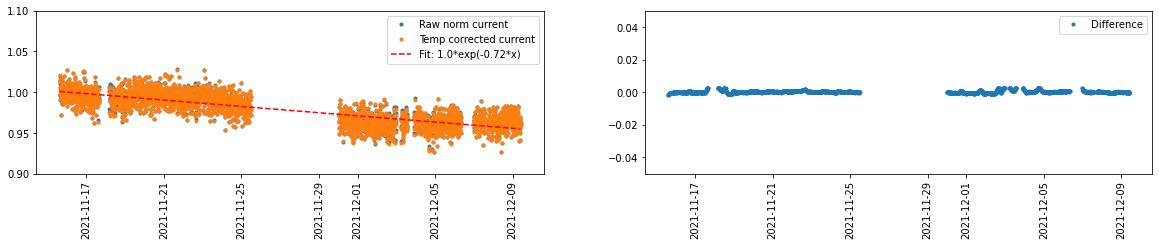

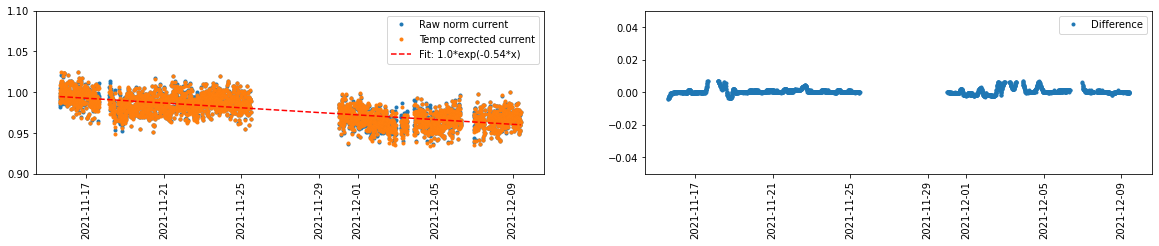

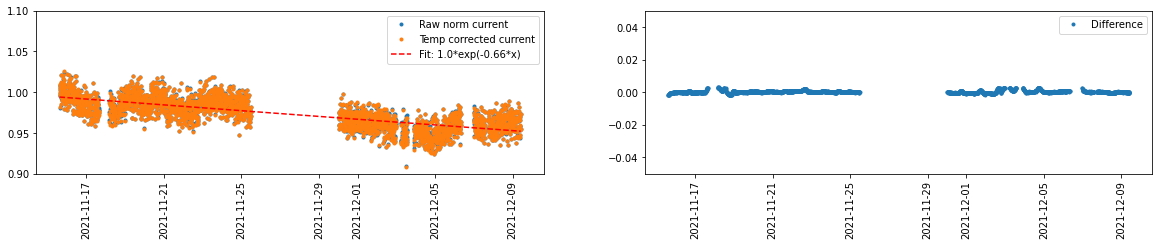

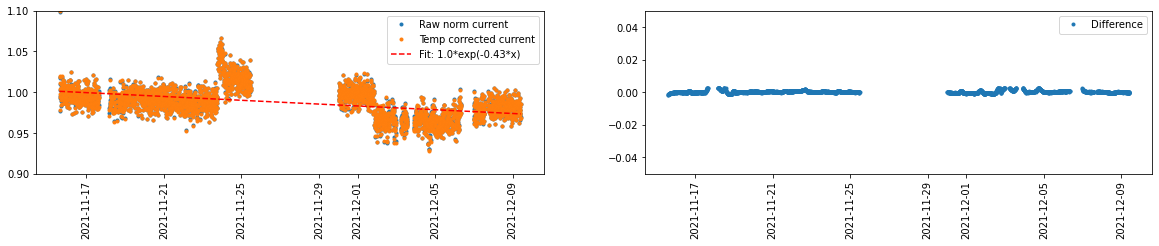

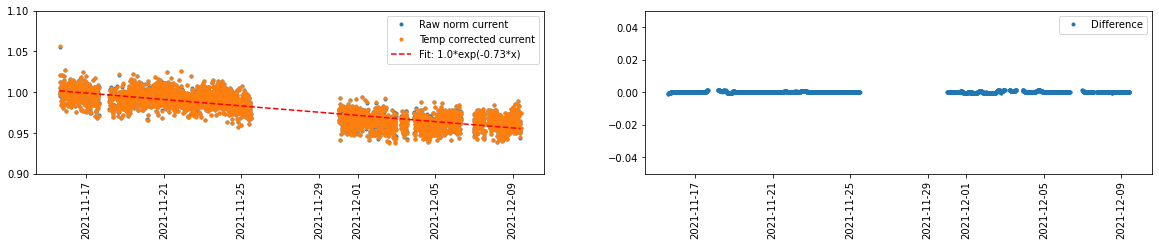

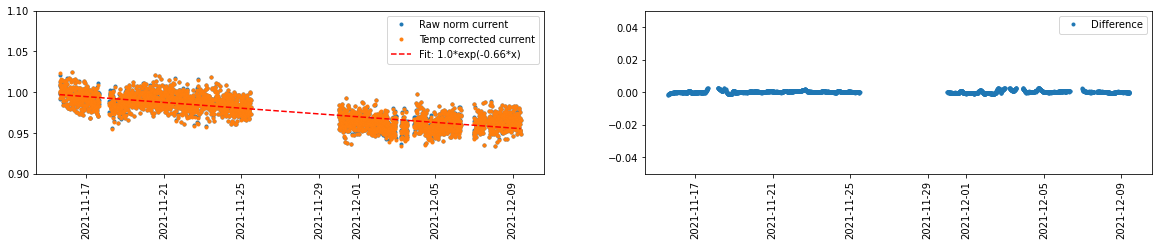

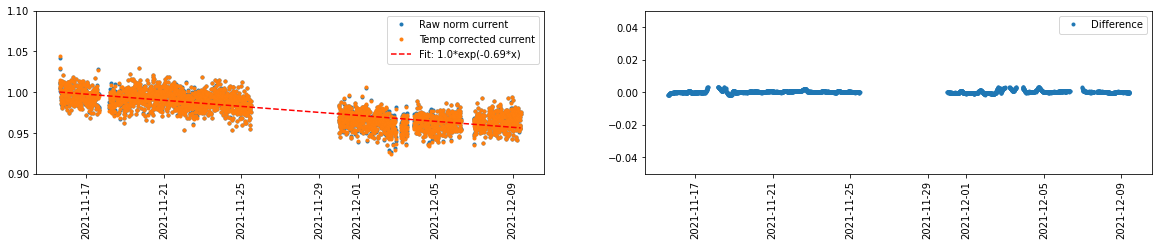

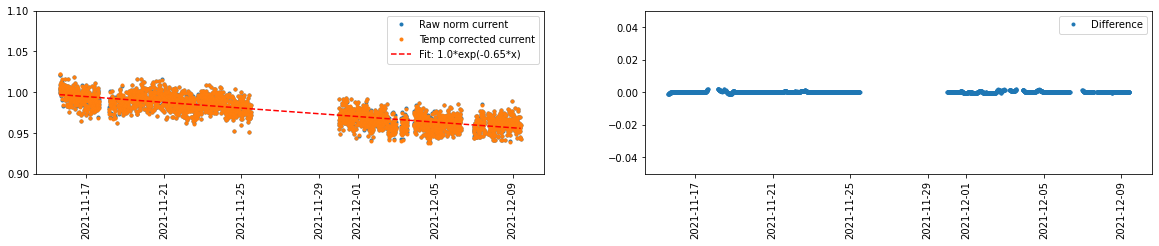

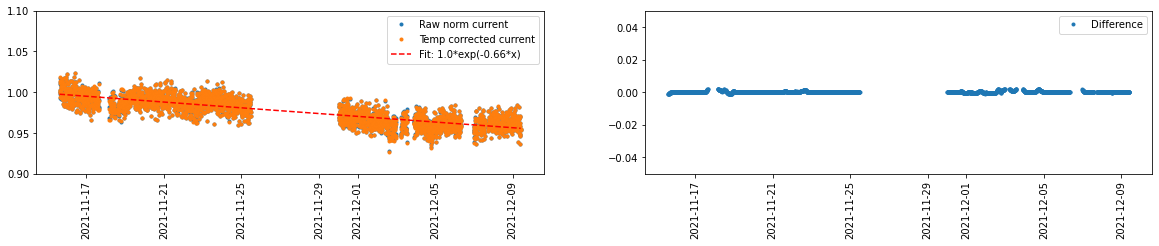

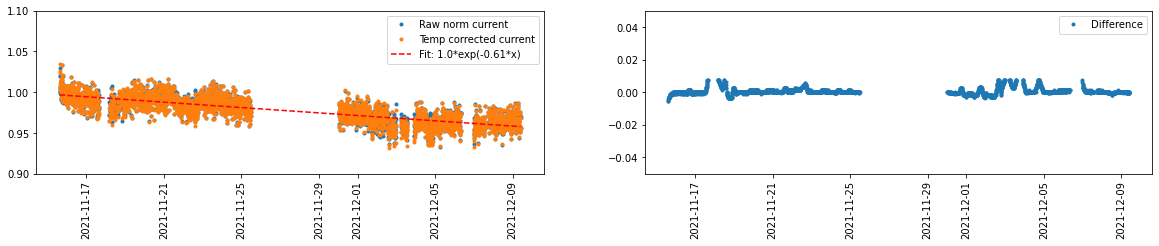

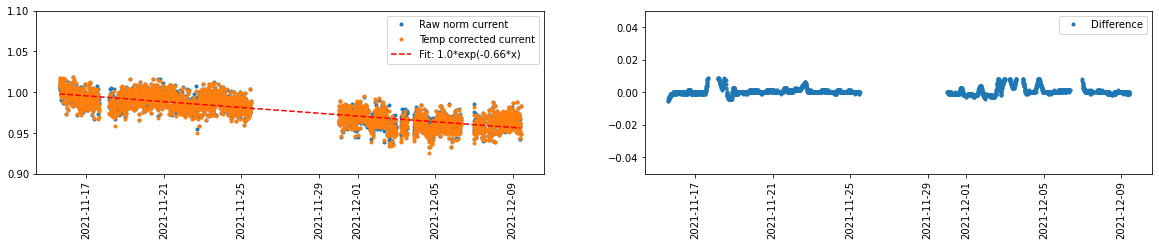

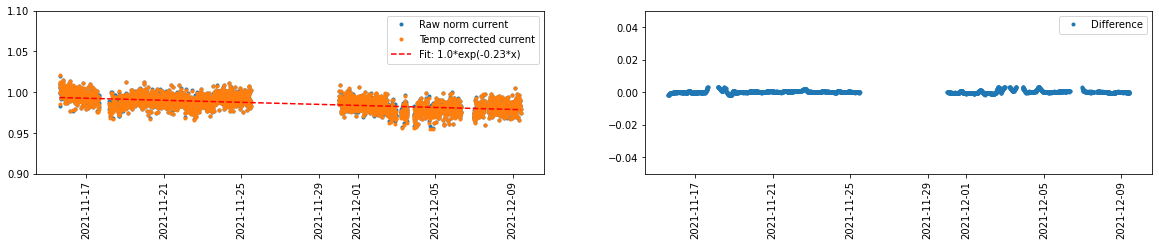

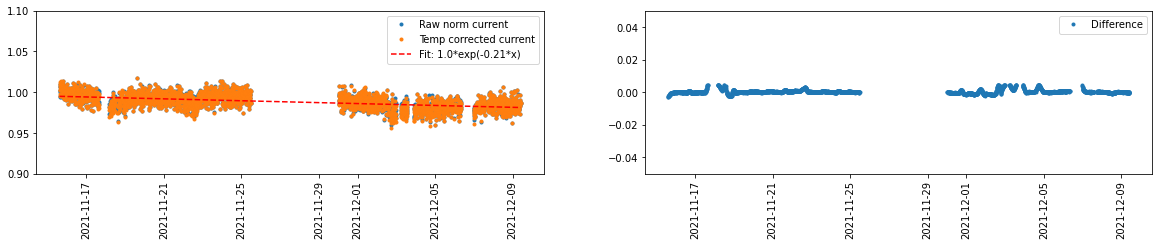

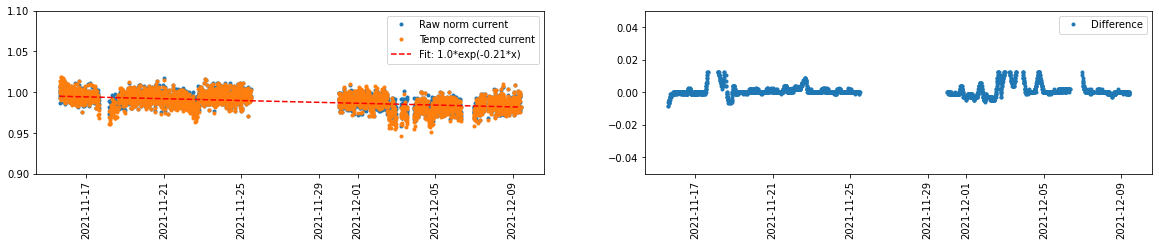

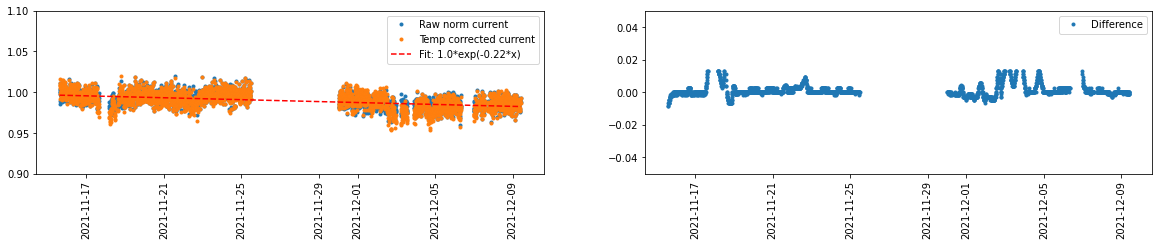

In [11]:
for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):

  fig, axs = plt.subplots(1,2, figsize=(20, 3));
  axs[0].plot(data_.date, data_[chan], '.', label='Raw norm current')

  y =  data_[chan]*(calib_df.query('chan==%d'%chan)['const'].to_numpy() + data_['temp']*calib_df.query('chan==%d'%chan)['slope'].to_numpy())
  axs[0].plot(data_.date, y, '.', label='Temp corrected current')
  axs[0].set_ylim(0.9, 1.1)
  axs[0].tick_params(axis='x', labelrotation = 90);
  popt, pcov = curve_fit(expo, X, y, p0=(1, 0.05))
  axs[0].plot(data_.date, expo(X, *popt), 'r--', label="Fit: " + str(round(popt[0], 1)) + "*exp("+str(-1*round(popt[1],2))+"*x)"); #fits an exponential to the function
  axs[0].legend()


  axs[1].plot(data_.date, data_[chan] - data_[chan]*(calib_df.query('chan==%d'%chan)['const'].to_numpy() + data_['temp']*calib_df.query('chan==%d'%chan)['slope'].to_numpy()), '.', label='Difference')
  axs[1].set_ylim(-0.05, 0.05)
  axs[1].legend()
  axs[1].tick_params(axis='x', labelrotation = 90);


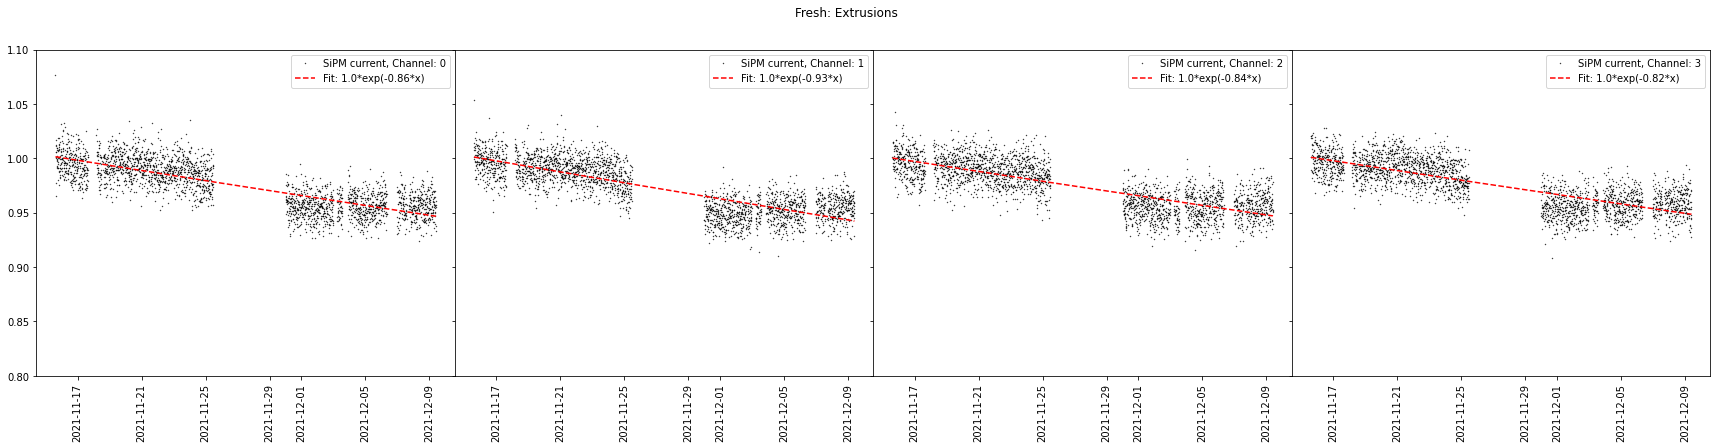

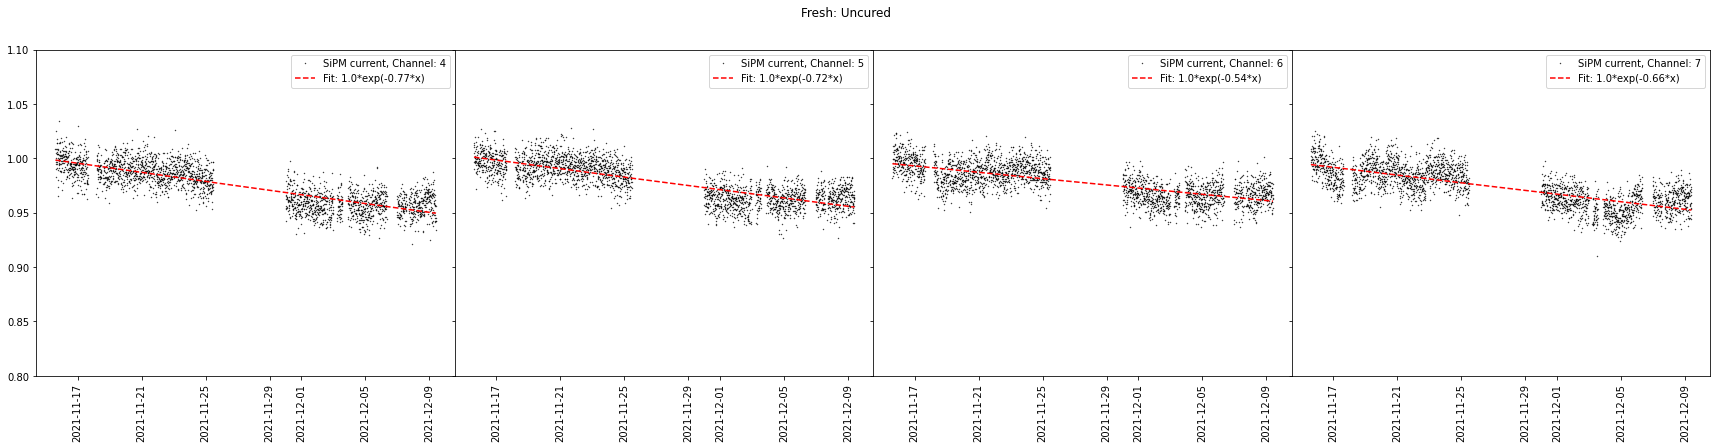

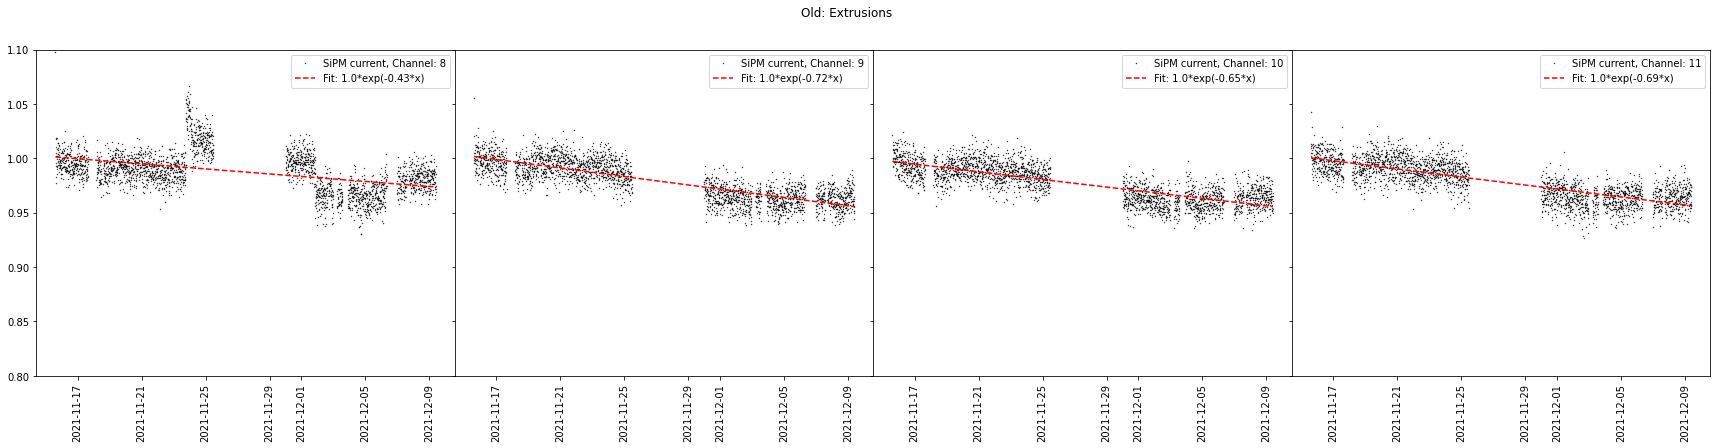

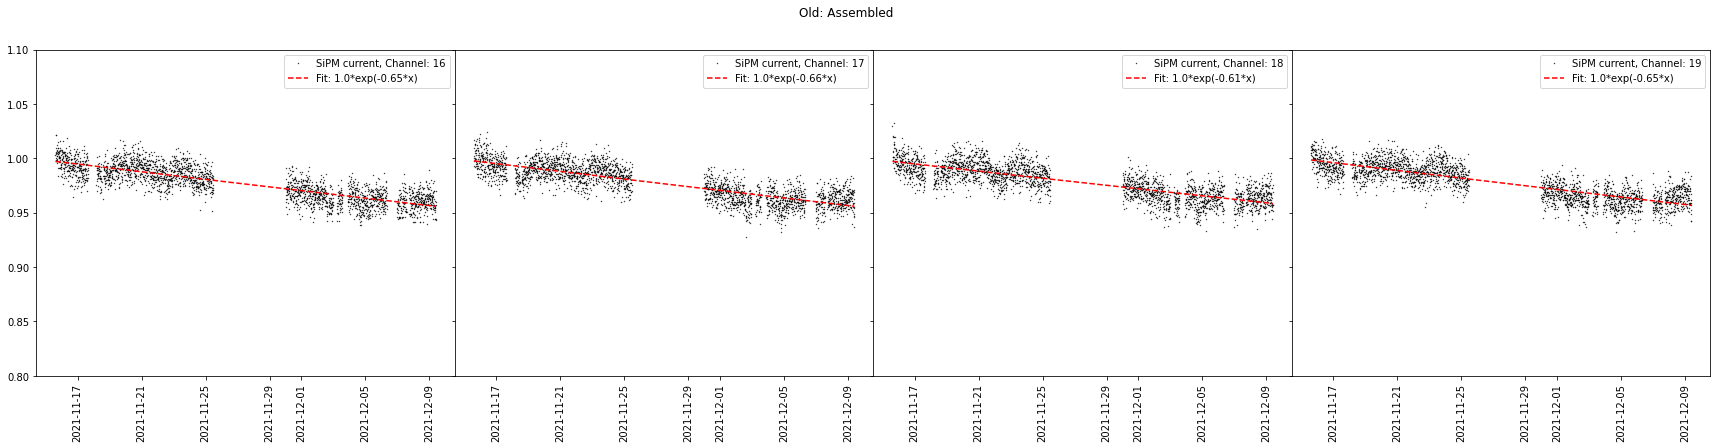

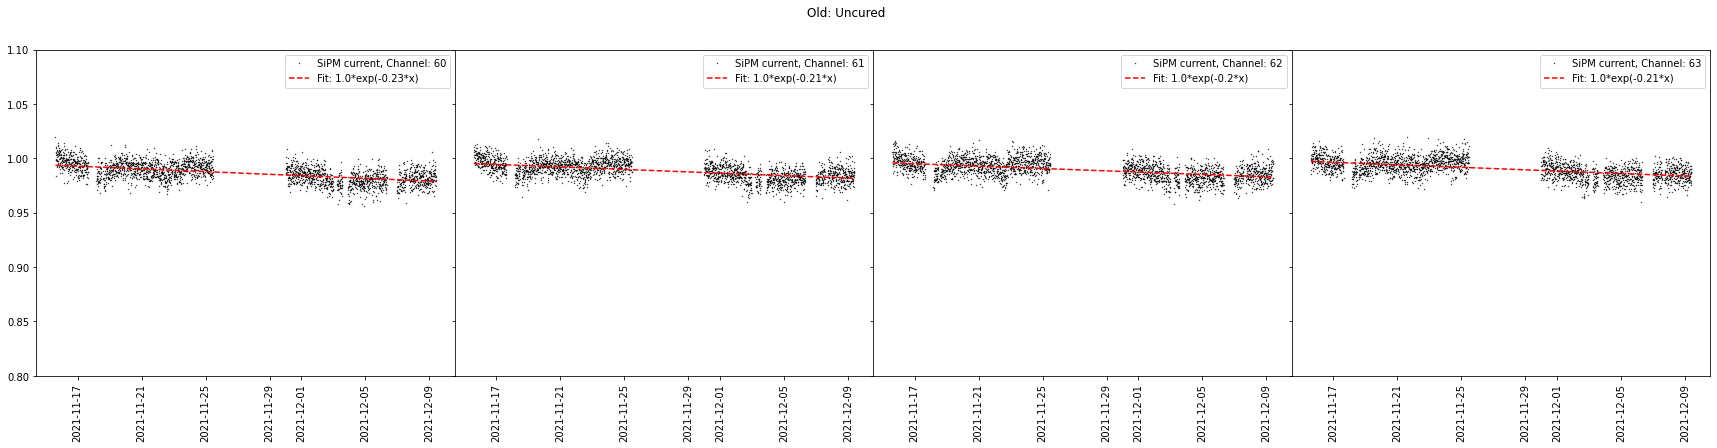

In [12]:
label = ''


for chan in it.chain(range(0, 12), range(16, 20), range(60,64)):
  if chan>=0 and chan<4:
    label='Fresh: Extrusions'
  if chan>=4 and chan<8:
    label='Fresh: Uncured'
  if chan>=8 and chan<12:
    label='Old: Extrusions'
  if chan>=16 and chan<20:
    label='Old: Assembled'
  if chan>=60 and chan<64:
    label='Old: Uncured'

    
  y = data_[chan]

  popt, pcov = curve_fit(expo, X, y, p0=(1, 0.05))

  if(chan%4==0):
    fig, axs = plt.subplots(1,4, figsize=(30, 6), sharey=True);
    fig.subplots_adjust(wspace=0)
  fig.suptitle(label)
  axs[chan%4].plot(data_.date, y, 'k.', label="SiPM current, Channel: %d"%chan, markersize=0.75);
  axs[chan%4].plot(data_.date, expo(X, *popt), 'r--', label="Fit: " + str(round(popt[0], 1)) + "*exp("+str(-1*round(popt[1],2))+"*x)"); #fits an exponential to the function
  axs[chan%4].legend()
  axs[chan%4].set_ylim(0.8,1.1);
  axs[chan%4].tick_params(axis='x', labelrotation = 90);

Text(0.5, 0, 'Temp [C]')

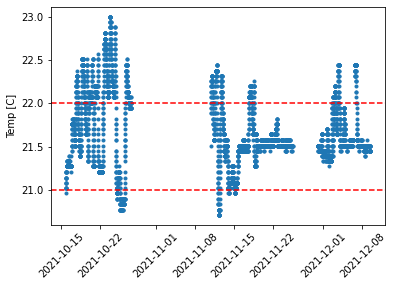

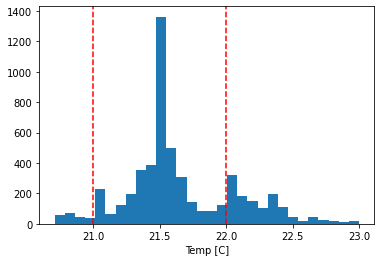

In [13]:
plt.plot(data.date, data.temp, '.', label='Temp [C]')
plt.axhline(y=MIN_TEMP, color='r', linestyle='--')
plt.axhline(y=MAX_TEMP, color='r', linestyle='--')
plt.xticks(rotation = 45);
plt.ylabel('Temp [C]')

plt.figure()
plt.hist(data.temp, bins=30, label='Temp [C]');
plt.axvline(x=MIN_TEMP, color='r', linestyle='--')
plt.axvline(x=MAX_TEMP, color='r', linestyle='--')
plt.xlabel('Temp [C]')

In [14]:
data.tail()

,date,source,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,temp,68,69,70,71,72
5393,2021-12-09 09:14:00,1,0.5971,0.6243,0.5437,0.5906,0.7956,0.8618,0.8071,0.8139,0.8240,0.8149,0.8201,0.7751,0.1921,0.1858,0.1825,0.1980,0.8762,0.8686,0.8077,0.8457,0.2170,0.2070,0.2078,0.2144,0.2489,0.2545,0.2671,0.2602,0.2747,0.2223,0.2195,0.2477,0.3297,0.2263,0.2037,0.2360,3.0728,0.3738,0.4290,0.4825,2.8639,0.4924,0.4180,0.4623,2.8721,0.6705,0.5481,0.6193,2.8617,0.6977,0.5822,0.6256,2.8593,0.5608,0.5768,0.6449,2.8704,0.3965,0.4224,0.4236,1.5373,1.6773,1.5901,1.5541,21.02,21.27,21.58,21.45,0.0,0.0,0.0,0.0,NaN
5394,2021-12-09 09:23:00,1,0.5863,0.6089,0.5550,0.5924,0.7900,0.8613,0.8098,0.8177,0.8365,0.8085,0.8256,0.7717,0.1891,0.1858,0.1768,0.1958,0.8571,0.8570,0.8205,0.8415,0.2183,0.2093,0.2057,0.2164,0.2493,0.2563,0.2672,0.2546,0.2773,0.2201,0.2200,0.2502,0.3332,0.2248,0.2107,0.2231,3.0729,0.3701,0.4363,0.4832,2.8639,0.4888,0.4086,0.4592,2.8721,0.6583,0.5658,0.6128,2.8617,0.7008,0.5948,0.6356,2.8594,0.5676,0.5763,0.6612,2.8705,0.3945,0.4258,0.4397,1.5323,1.6558,1.5912,1.5734,21.08,21.27,21.58,21.51,0.0,0.0,0.0,0.0,NaN
5395,2021-12-09 09:33:00,1,0.5943,0.6211,0.5434,0.5972,0.8053,0.8509,0.8016,0.8088,0.8223,0.8174,0.8150,0.7694,0.1975,0.1828,0.1799,0.1985,0.8670,0.8493,0.8038,0.8449,0.2192,0.2080,0.2034,0.2162,0.2518,0.2472,0.2644,0.2610,0.2789,0.2164,0.2194,0.2460,0.3273,0.2208,0.2046,0.2478,3.0730,0.3723,0.4252,0.4867,2.8638,0.4993,0.4135,0.4619,2.8721,0.6581,0.5560,0.6235,2.8617,0.7009,0.5930,0.6262,2.8595,0.5758,0.5800,0.6608,2.8704,0.3967,0.4283,0.4213,1.5379,1.6788,1.5948,1.5728,21.08,21.27,21.58,21.51,0.0,0.0,0.0,0.0,NaN
5396,2021-12-09 09:42:00,1,0.5953,0.6237,0.5388,0.5856,0.7956,0.8604,0.8082,0.8189,0.8318,0.8245,0.8237,0.7818,0.1952,0.1858,0.1839,0.2024,0.8689,0.8632,0.8075,0.8639,0.2130,0.2121,0.2074,0.2173,0.2547,0.2576,0.2685,0.2612,0.2775,0.2148,0.2198,0.2478,0.3499,0.2194,0.2093,0.2306,3.0729,0.3739,0.4262,0.4840,2.8638,0.4842,0.4128,0.4571,2.8720,0.6613,0.5518,0.6266,2.8615,0.6992,0.5819,0.6226,2.8594,0.5730,0.5732,0.6555,2.8705,0.3967,0.4203,0.4281,1.5316,1.6767,1.5721,1.5771,21.02,21.27,21.64,21.51,0.0,0.0,0.0,0.0,NaN
5397,2021-12-09 09:51:00,1,0.5841,0.6291,0.5441,0.5777,0.7978,0.8587,0.8166,0.8059,0.8201,0.8117,0.8123,0.7803,0.1940,0.1917,0.1746,0.1991,0.8563,0.8623,0.8161,0.8389,0.2192,0.2034,0.2043,0.2179,0.2512,0.2577,0.2706,0.2550,0.2788,0.2142,0.2231,0.2457,0.3359,0.2189,0.2094,0.2196,3.0729,0.3709,0.4227,0.4816,2.8639,0.4896,0.4091,0.4481,2.8722,0.6536,0.5610,0.6018,2.8615,0.6981,0.5956,0.6297,2.8593,0.5575,0.5716,0.6511,2.8705,0.3963,0.4261,0.4319,1.5251,1.6758,1.5712,1.5692,21.02,21.27,21.64,21.51,0.0,0.0,0.0,0.0,NaN
